In [ ]:
''' Overview of the Telco Customer Churn modelling
Downlaod wind power dataset form kaggle:
https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data
-- Exploratory Data Analysis (EDA), data cleaning and transformation was performed, 
-- imblanced dataset was handelled with under sampling, oversampling and SMOTETomek techniques
-- binary classification was implemented with ANN method
'''

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [33]:
df= pd.DataFrame(pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA and Data Cleaning

In [34]:
for col in df.columns:
    print(col, df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [35]:
#drop customerID
df.drop("customerID", axis=1, inplace=True)

#TotalCharges to numeric
df=df[df["TotalCharges"]!=' ']
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"])

# make 0,1 for some column
df["gender"]=df["gender"].map({'Female': 0 ,'Male': 1})
df.replace(['No phone service','No internet service'],"No", inplace=True)

yes_no_col=["Partner","Dependents","PhoneService","MultipleLines","OnlineSecurity",
           "OnlineBackup","DeviceProtection","TechSupport","StreamingTV",
           "StreamingMovies","PaperlessBilling","Churn"]

for i in yes_no_col:
    df[i]=df[i].map({'Yes': 0 ,'No': 1})

for i in yes_no_col:
    df[i].replace({'Yes': 0 ,'No': 1}, inplace=True)


# get_dummies for some columns
df=pd.get_dummies(df,["InternetService","Contract","PaymentMethod"], dtype=float)

#scale for some columns
scale_col=["tenure","MonthlyCharges","TotalCharges"]
scaler=MinMaxScaler()
df[scale_col]=scaler.fit_transform(df[scale_col])

In [36]:
df["Churn"].value_counts()

Churn
1    5163
0    1869
Name: count, dtype: int64

# Handdel imblanced dataset (under sampling, oversampling and SMOTETomeksmt methods)

In [25]:
Churn_class_0=df[df["Churn"]==0] 
Churn_class_1=df[df["Churn"]==1] 
Churn_class_1_balanced=Churn_class_1.sample(Churn_class_0.shape[0])
df_balanced=pd.concat([Churn_class_0,Churn_class_1_balanced], axis=0)

In [37]:
X=df.drop('Churn', axis=1)
y=df['Churn']
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
X_blanced, y_blanced = smt.fit_resample(X, y)

/usr/local/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [38]:
xtrain,xtext,ytrain,ytest=train_test_split(X_blanced, y_blanced,test_size=0.25, random_state=100,)

In [39]:
model=Sequential([
    Dense(26, input_dim=26, activation='relu'),
    Dense(15,activation='relu'),
    Dense(1,activation='sigmoid'),
    ])

model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=100)

Epoch 1/100
229/229 [==============================] - 1s 2ms/step - loss: 0.5402 - accuracy: 0.7514
Epoch 2/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4485 - accuracy: 0.7871
Epoch 3/100
229/229 [==============================] - 1s 2ms/step - loss: 0.4406 - accuracy: 0.7875
Epoch 4/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.7922
Epoch 5/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7971
Epoch 6/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7982
Epoch 7/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.8015
Epoch 8/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4230 - accuracy: 0.8020
Epoch 9/100
229/229 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.8022
Epoch 10/100
229/229 [==============================] - 1s 3ms/step - loss: 0.4168 - accura

In [40]:
model.evaluate(xtext,ytest)

77/77 [==============================] - 0s 2ms/step - loss: 0.4013 - accuracy: 0.8142


[0.4013271629810333, 0.8141919374465942]

In [41]:
ypred=np.round(model.predict(xtext))

77/77 [==============================] - 0s 1ms/step


In [50]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1249
           1       0.82      0.80      0.81      1189

    accuracy                           0.81      2438
   macro avg       0.81      0.81      0.81      2438
weighted avg       0.81      0.81      0.81      2438



<Axes: >

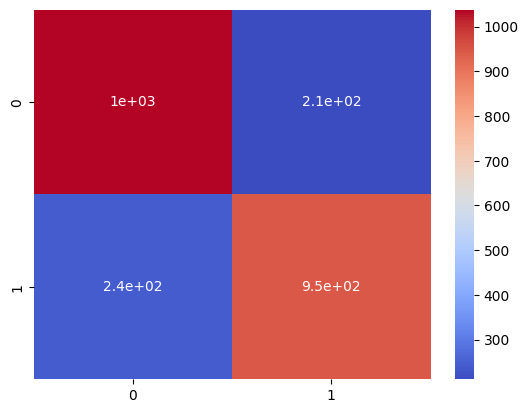

In [48]:
sns.heatmap(confusion_matrix(ytest,ypred),annot=True,cmap="coolwarm")